In [65]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from astropy.coordinates import ICRS, Galactic, Galactocentric


In [66]:
vetted_RGB = 'merged_data.fits'

with fits.open(vetted_RGB) as hdul:
    data = hdul[1].data  
    
    df_RGB = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [67]:
high_quality = 'high_quality_sample.fits'

with fits.open(high_quality) as hdul:
    # Access the first table extension
    data = hdul[1].data
    
    # Convert to DataFrame
    df_quality = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name] for col in data.columns})


In [68]:
filtered = 'filtered_high_quality_sample.fits'

with fits.open(filtered) as hdul:
    # Access the first table extension
    data = hdul[1].data
    
    # Convert to DataFrame
    df_filtered = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name] for col in data.columns})


In [69]:
pd.set_option('display.max_columns', None)
df_filtered.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V)
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163


In [70]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from galpy.util.coords import lbd_to_XYZ, XYZ_to_galcencyl

# Extract relevant columns
l = df_filtered['l'].values  # Galactic longitude in degrees
b = df_filtered['b'].values  # Galactic latitude in degrees
rpgeo = df_filtered['rpgeo'].values  # Distance in parsecs

# Convert Galactic coordinates to Cartesian using galpy
xyz = lbd_to_XYZ(l, b, rpgeo, degree=True)
x, y, z = xyz.T  # Unpacking the array

# Transform to Galactocentric cylindrical coordinates
Xsun = 8.2  # Distance of the Sun from the Galactic Centre in kpc
Zsun = 0.025  # Sun's height above the midplane in kpc
R_phi_z = XYZ_to_galcencyl(x, y, z, Xsun=Xsun, Zsun=Zsun, _extra_rot=True)
R, phi, z_gal = R_phi_z.T  # Unpacking the results

# Add Galactocentric cylindrical coordinates to the DataFrame
df_filtered["R_gal"] = R
df_filtered["phi_gal"] = phi
df_filtered["Z_gal"] = z_gal

df_filtered.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),R_gal,phi_gal,Z_gal
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,470.485258,0.055731,-520.632142
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1268.325930,0.060773,-1399.358389
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,308.483632,0.064184,-338.602406
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1245.041147,0.073347,-1400.635394
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,793.842786,0.072479,-877.288236


In [71]:
# Define the Sun's velocity with respect to the Galactic center
v_sun = CartesianDifferential([11.1, 245., 7.25] * u.km / u.s)

# Define the Galactocentric frame
gc_frame = Galactocentric(galcen_distance=8.1 * u.kpc, 
                          z_sun=25. * u.pc, 
                          galcen_v_sun=v_sun)

In [80]:
# Extract the columns as numpy arrays
ra = df_filtered['ra'].values * u.deg
dec = df_filtered['dec'].values * u.deg
distance = df_filtered['rpgeo'].values * u.pc  # Assuming parallax is in mas
pmra = df_filtered['pmra'].values * u.mas / u.yr
pmdec = df_filtered['pmdec'].values * u.mas / u.yr
vlos = df_filtered['radial_velocity'].values * u.km / u.s

# Create a SkyCoord object for all sources at once
coords = ICRS(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=vlos)

# Transform all coordinates to the Galactocentric frame
cg = coords.transform_to(gc_frame)

# Extract the velocity components in Cartesian coordinates (v_x, v_y, v_z)
v_x = cg.v_x.to(u.km / u.s).value
v_y = cg.v_y.to(u.km / u.s).value
v_z = cg.v_z.to(u.km / u.s).value

df_filtered['v_phi'] = v_y

In [73]:
# Extract the columns as numpy arrays
ra = df_RGB['ra'].values * u.deg
dec = df_RGB['dec'].values * u.deg
distance = df_RGB['rpgeo'].values * u.pc  # Assuming parallax is in mas
pmra = df_RGB['pmra'].values * u.mas / u.yr
pmdec = df_RGB['pmdec'].values * u.mas / u.yr
vlos = df_RGB['radial_velocity'].values * u.km / u.s

# Create a SkyCoord object for all sources at once
coords = ICRS(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=vlos)

# Transform all coordinates to the Galactocentric frame
cg = coords.transform_to(gc_frame)

# Extract the velocity components in Cartesian coordinates (v_x, v_y, v_z)
v_x = cg.v_x.to(u.km / u.s).value
v_y = cg.v_y.to(u.km / u.s).value
v_z = cg.v_z.to(u.km / u.s).value

df_RGB['v_phi'] = v_y

# Constants
galcen_distance = 8.2 * u.kpc  # Distance to Galactic centre
z_sun = 25.0 * u.pc           # Sun's distance from Galactic plane
v_sun = CartesianDifferential([11.1, 245.0, 7.25] * u.km / u.s)  # Sun's velocity
gc_frame = Galactocentric(galcen_distance=galcen_distance, z_sun=z_sun, galcen_v_sun=v_sun)

def calculate_vphi_vectorised(df):
    # Convert input columns to astropy quantities
    l = df['l'].values * u.deg
    b = df['b'].values * u.deg
    rpgeo = df['rpgeo'].values * u.pc
    pmra = df['pmra'].values * u.mas / u.yr
    pmdec = df['pmdec'].values * u.mas / u.yr
    vlos = df['radial_velocity'].values * u.km / u.s

    # Create a SkyCoord object in Galactic coordinates
    coords = SkyCoord(l=l, b=b, distance=rpgeo.to(u.kpc), # put in ra and dec as dont have pro[er motions in r and b]
                      pm_ra_cosb=pmra, pm_dec=pmdec, #look at package
                      radial_velocity=vlos, frame='galactic')
    
    #frame in icrs
    # everything else in ra and dec
    

    # Transform to Galactocentric frame
    galactic_coords = coords.transform_to(gc_frame)
    galactic_coords.representation_type = 'cylindrical'

    # Extract rho (cylindrical radius)
    rho_kpc = galactic_coords.rho.to(u.kpc).value  # Cylindrical radius in kpc
    rho_km = rho_kpc * (3.08567758128e+16)  # Convert kpc to km

    # Extract d_phi from Galactocentric frame (signed angular velocity)
    d_phi_rad_s = galactic_coords.d_phi.to(u.rad / u.s).value

    # Compute v_phi
    v_phi = - rho_km * d_phi_rad_s  # Linear azimuthal velocity in km/s
    return v_phi


In [74]:
df_filtered['v_phi'].describe()

count    3.079600e+06
mean     1.931218e+02
std      5.552272e+01
min     -5.002737e+02
25%      1.730645e+02
50%      2.040717e+02
75%      2.275432e+02
max      4.812105e+02
Name: v_phi, dtype: float64

In [75]:
data_array = np.array(
    list(df_filtered.itertuples(index=False, name=None)),
    dtype=[(col, df_filtered[col].dtype.type) for col in df_filtered.columns]
)

hdu = fits.BinTableHDU(data_array)

output_fits_filename = 'vphi_dataset.fits'
hdu.writeto(output_fits_filename, overwrite=True)

print(f"FITS file saved as '{output_fits_filename}'")

FITS file saved as 'vphi_dataset.fits'


# Calculate v_phi for the entire DataFrame
df_RGB['v_phi'] = calculate_vphi_vectorised(df_RGB)

df_RGB['v_phi'].describe()

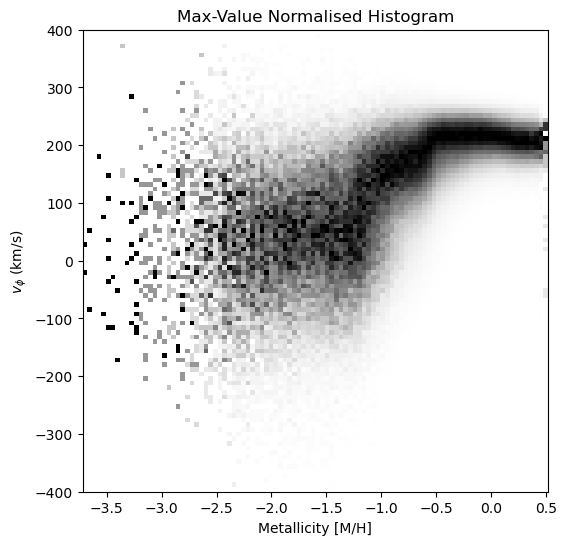

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Ensure no NaN values in the required columns
df_filtered = df_filtered.dropna(subset=['mh_xgboost', 'v_phi'])

# Extract metallicity and v_phi
metallicity = df_filtered['mh_xgboost']
v_phi = df_filtered['v_phi']

# Define the number of bins
num_bins = 100

# Create the bin edges for metallicity and v_phi
metallicity_bins = np.linspace(metallicity.min(), metallicity.max(), num_bins + 1)
v_phi_bins = np.linspace(-400, 400, num_bins + 1)

# Create the 2D histogram
hist, metallicity_edges, v_phi_edges = np.histogram2d(
    metallicity, v_phi, bins=[metallicity_bins, v_phi_bins]
)

# Normalise each column by its max value
hist_max_normalised = hist / np.max(hist, axis=1, keepdims=True)
hist_max_normalised[np.isnan(hist_max_normalised)] = 0  # Avoid NaNs from zero division

# Plot the max-value normalised histogram
plt.figure(figsize=(6, 6))
plt.pcolormesh(
    metallicity_edges, v_phi_edges, hist_max_normalised.T,
    cmap='Greys', norm=Normalize(vmin=0.001, vmax=np.max(hist_max_normalised), clip=True)
)
plt.xlabel('Metallicity [M/H]')
plt.ylabel(r'$v_\phi$ (km/s)')
plt.title('Max-Value Normalised Histogram')

# Show plot
plt.show()


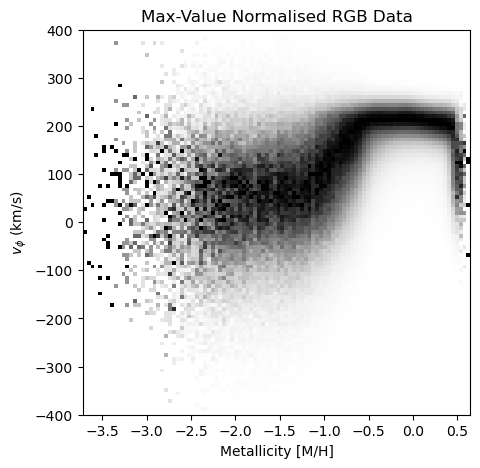

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Ensure no NaN values in the required columns
df_RGB = df_RGB.dropna(subset=['mh_xgboost', 'v_phi'])

# Extract metallicity and v_phi
metallicity = df_RGB['mh_xgboost']
v_phi = df_RGB['v_phi']

# Define the number of bins
num_bins = 100

# Create the bin edges for metallicity and v_phi
metallicity_bins = np.linspace(metallicity.min(), metallicity.max(), num_bins + 1)
v_phi_bins = np.linspace(-400, 400, num_bins + 1)

# Create the 2D histogram
hist, metallicity_edges, v_phi_edges = np.histogram2d(
    metallicity, v_phi, bins=[metallicity_bins, v_phi_bins]
)

# Normalise each column by its max value
hist_max_normalised = hist / np.max(hist, axis=1, keepdims=True)
hist_max_normalised[np.isnan(hist_max_normalised)] = 0  # Avoid NaNs from zero division

# Plot the max-value normalised histogram
plt.figure(figsize=(5, 5))
plt.pcolormesh(
    metallicity_edges, v_phi_edges, hist_max_normalised.T,
    cmap='Greys', norm=Normalize(vmin=0, vmax=1)
)

# Set axis labels and title
plt.xlabel('Metallicity [M/H]')
plt.ylabel(r'$v_\phi$ (km/s)')
plt.title('Max-Value Normalised RGB Data')
plt.ylim(-400, 400)

# Show plot
plt.show()


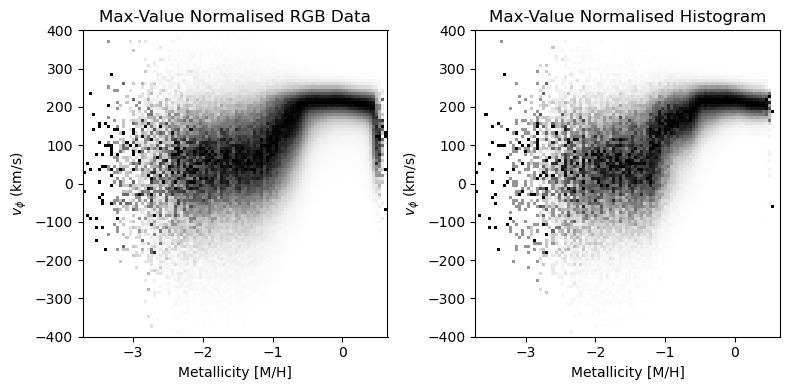

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import warnings

# Ignore runtime warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# Ensure no NaN values in the required columns
df_filtered = df_filtered.dropna(subset=['mh_xgboost', 'v_phi'])
df_RGB = df_RGB.dropna(subset=['mh_xgboost', 'v_phi'])

# Extract metallicity and v_phi for both datasets
metallicity_filtered = df_filtered['mh_xgboost']
v_phi_filtered = df_filtered['v_phi']
metallicity_RGB = df_RGB['mh_xgboost']
v_phi_RGB = df_RGB['v_phi']

# Define the number of bins
num_bins = 100

# Create the bin edges for metallicity and v_phi
metallicity_bins = np.linspace(min(metallicity_filtered.min(), metallicity_RGB.min()), 
                               max(metallicity_filtered.max(), metallicity_RGB.max()), num_bins + 1)
v_phi_bins = np.linspace(-400, 400, num_bins + 1)

# Create 2D histograms for both datasets
hist_filtered, metallicity_edges, v_phi_edges = np.histogram2d(
    metallicity_filtered, v_phi_filtered, bins=[metallicity_bins, v_phi_bins]
)

hist_RGB, _, _ = np.histogram2d(
    metallicity_RGB, v_phi_RGB, bins=[metallicity_bins, v_phi_bins]
)

# Normalise each column by its max value
hist_max_normalised_filtered = hist_filtered / np.max(hist_filtered, axis=1, keepdims=True)
hist_max_normalised_RGB = hist_RGB / np.max(hist_RGB, axis=1, keepdims=True)

# Avoid NaNs from zero division
hist_max_normalised_filtered[np.isnan(hist_max_normalised_filtered)] = 0
hist_max_normalised_RGB[np.isnan(hist_max_normalised_RGB)] = 0

# Create figure with 2 subplots (2 across, 1 down)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 3 across, 4 down per subplot

# Plot RGB data (swapped to the left)
ax1 = axes[0]
pcm1 = ax1.pcolormesh(
    metallicity_edges, v_phi_edges, hist_max_normalised_RGB.T,
    cmap='Greys'
)
ax1.set_xlabel('Metallicity [M/H]')
ax1.set_ylabel(r'$v_\phi$ (km/s)')
ax1.set_title('Max-Value Normalised RGB Data')

# Plot filtered data (swapped to the right)
ax2 = axes[1]
pcm2 = ax2.pcolormesh(
    metallicity_edges, v_phi_edges, hist_max_normalised_filtered.T,
    cmap='Greys', norm=Normalize(vmin=0, vmax=1)
)
ax2.set_xlabel('Metallicity [M/H]')
ax2.set_ylabel(r'$v_\phi$ (km/s)')
ax2.set_title('Max-Value Normalised Histogram')

# Adjust layout
plt.tight_layout()
plt.show()
